In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 13, 'pdf.fonttype': 42})

In [2]:
timing_data = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/All_data_Jun11.csv")
sample_ids = timing_data[timing_data['cohort'] == 'PCAWG']['ID'].tolist()

PCAWG_HRD_WGD_SVs = pd.read_csv("/Volumes/extSSD/park_lab/HRDTimer_Analysis/PCAWG_Breast_SV_data_v3.csv")
PCAWG_HRD_WGD_SVs = PCAWG_HRD_WGD_SVs[['aliquot_id','minorCN_0_CNstep_1', 'minorCN_0_CNstep_2', 'minorCN_1_CNstep_1', 'minorCN_1_CNstep_2', 'minorCN_2_CNstep_1', 'minorCN_2_CNstep_2']]
PCAWG_HRD_WGD_SVs.rename(columns={'aliquot_id': 'ID'}, inplace=True)
PCAWG_HRD_WGD_SVs = PCAWG_HRD_WGD_SVs[PCAWG_HRD_WGD_SVs['ID'].isin(sample_ids)]
PCAWG_HRD_WGD_SVs.head(2)

,ID,minorCN_0_CNstep_1,minorCN_0_CNstep_2,minorCN_1_CNstep_1,minorCN_1_CNstep_2,minorCN_2_CNstep_1,minorCN_2_CNstep_2
20,a85cf239-ff51-46e7-9b88-4c2cb49c66b9,NaN,NaN,NaN,NaN,NaN,NaN
21,fc806c50-2f6e-418d-e040-11ac0d485f01,19.0,8.0,9.0,4.0,10.0,0.0


In [3]:
def calculate_pi1_sv(timing_result_df):

    df = timing_result_df.copy()
    columns = {
        0: ('minorCN_0_CNstep_1', 'minorCN_0_CNstep_2'),
        1: ('minorCN_1_CNstep_1', 'minorCN_1_CNstep_2'),
        2: ('minorCN_2_CNstep_1', 'minorCN_2_CNstep_2')
    }
    
    for idx, row in df.iterrows():
        
        for minCN in [0, 2, 1]:
            cn_step_1, cn_step_2 = columns[minCN]
            N_SV_cn1 = row[cn_step_1]
            N_SV_cn2 = row[cn_step_2]
            
            try:
                pi2_SV = N_SV_cn1 / (N_SV_cn2 + N_SV_cn1)
            except ZeroDivisionError:
                pi2_SV = np.nan

            df.loc[idx, f'pi1_2{minCN}_SV'] = pi2_SV
        
    return df 

pi1_SVs = calculate_pi1_sv(PCAWG_HRD_WGD_SVs)

cols_to_sum = [
    'minorCN_0_CNstep_1', 'minorCN_0_CNstep_2',
    'minorCN_1_CNstep_1', 'minorCN_1_CNstep_2',
    'minorCN_2_CNstep_1', 'minorCN_2_CNstep_2'
]

pi1_SVs = pi1_SVs[
    pi1_SVs[cols_to_sum].sum(axis=1, skipna=True) > 25
]

pi1_SVs['N_SV_total_20'] = pi1_SVs['minorCN_0_CNstep_1'] + pi1_SVs['minorCN_0_CNstep_2']
pi1_SVs['N_SV_total_21'] = pi1_SVs['minorCN_1_CNstep_1'] + pi1_SVs['minorCN_1_CNstep_2']
pi1_SVs['N_SV_total_22'] = pi1_SVs['minorCN_2_CNstep_1'] + pi1_SVs['minorCN_2_CNstep_2']

pi1_SVs = pi1_SVs[
    (pi1_SVs['N_SV_total_20'] >= 5) &
    (pi1_SVs['N_SV_total_22'] >= 5)
]

# Zero out weights where pi1_SV is NaN
N_20_adj = pi1_SVs['N_SV_total_20'].where(~pi1_SVs['pi1_20_SV'].isna(), 0)
N_22_adj = pi1_SVs['N_SV_total_22'].where(~pi1_SVs['pi1_22_SV'].isna(), 0)

# Weighted sum ignoring NaNs
pi1_SVs['pi1_SV_weighted_sum'] = (
    pi1_SVs['pi1_20_SV'].fillna(0) * N_20_adj +
    pi1_SVs['pi1_22_SV'].fillna(0) * N_22_adj
)

# Weighted total (only where pi1_SV is not NaN)
pi1_SVs['N_SV_weighted_total'] = N_20_adj + N_22_adj

# Final weighted average
pi1_SVs['pi1_SV_weighted_avg'] = np.where(
    pi1_SVs['N_SV_weighted_total'] > 0,
    pi1_SVs['pi1_SV_weighted_sum'] / pi1_SVs['N_SV_weighted_total'],
    np.nan
)

pi1_SVs

,ID,minorCN_0_CNstep_1,minorCN_0_CNstep_2,minorCN_1_CNstep_1,minorCN_1_CNstep_2,minorCN_2_CNstep_1,minorCN_2_CNstep_2,pi1_20_SV,pi1_22_SV,pi1_21_SV,N_SV_total_20,N_SV_total_21,N_SV_total_22,pi1_SV_weighted_sum,N_SV_weighted_total,pi1_SV_weighted_avg
21,fc806c50-2f6e-418d-e040-11ac0d485f01,19.0,8.0,9.0,4.0,10.0,0.0,0.703704,1.000000,0.692308,27.0,13.0,10.0,29.0,37.0,0.783784
24,fc9f6cb0-ceb9-790d-e040-11ac0c480ad1,10.0,16.0,4.0,6.0,4.0,1.0,0.384615,0.800000,0.400000,26.0,10.0,5.0,14.0,31.0,0.451613
27,fc8130e0-a38a-23b9-e040-11ac0c48327f,25.0,5.0,40.0,14.0,17.0,4.0,0.833333,0.809524,0.740741,30.0,54.0,21.0,42.0,51.0,0.823529
28,fc8130e3-01ba-c740-e040-11ac0c483291,3.0,30.0,14.0,16.0,23.0,59.0,0.090909,0.280488,0.466667,33.0,30.0,82.0,26.0,115.0,0.226087
30,fc8130df-90ba-5d94-e040-11ac0d485e0c,18.0,19.0,13.0,13.0,9.0,3.0,0.486486,0.750000,0.500000,37.0,26.0,12.0,27.0,49.0,0.551020
31,fc8130e0-0f1a-b6eb-e040-11ac0c48328f,7.0,1.0,8.0,6.0,5.0,3.0,0.875000,0.625000,0.571429,8.0,14.0,8.0,12.0,16.0,0.750000
34,fc8130df-8ec8-5b1e-e040-11ac0d485e06,59.0,80.0,12.0,3.0,14.0,22.0,0.424460,0.388889,0.800000,139.0,15.0,36.0,73.0,175.0,0.417143
37,f393bb08-4121-cad8-e040-11ac0d484535,6.0,16.0,12.0,16.0,18.0,49.0,0.272727,0.268657,0.428571,22.0,28.0,67.0,24.0,89.0,0.269663
38,f393bb07-270c-2c93-e040-11ac0d484533,9.0,22.0,7.0,16.0,9.0,24.0,0.290323,0.272727,0.304348,31.0,23.0,33.0,18.0,64.0,0.281250
39,f221cbb5-eefa-187f-e040-11ac0c481708,15.0,9.0,64.0,16.0,30.0,14.0,0.625000,0.681818,0.800000,24.0,80.0,44.0,45.0,68.0,0.661765


## Load SNV results (pi1_SBS3)

In [16]:
df_all = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/All_data_Jun11.csv")

# Parse pi2_SBS1 and N_mut_all strings into lists of floats
def parse_list_column(col):
    return col.apply(lambda x: [float(i) for i in x.strip('[]').split(', ')] if pd.notnull(x) else [])

df_all['pi1_SBS3_list'] = parse_list_column(df_all['pi1SBS3'])
df_all['N_mut_all_list'] = parse_list_column(df_all['N_mut_all'])

# Compute weighted average of pi2_SBS1 at indices 0 and 2
def weighted_pi2_sbs1(row):
    pi2_list = row['pi1_SBS3_list']
    nmut_list = row['N_mut_all_list']
    if len(pi2_list) >= 3 and len(nmut_list) >= 3:
        num = pi2_list[0] * nmut_list[0] + pi2_list[2] * nmut_list[2]
        denom = nmut_list[0] + nmut_list[2]
        return num / denom if denom > 0 else np.nan
    else:
        return np.nan

df_all['pi1_SBS3_weighted_0_2'] = df_all.apply(weighted_pi2_sbs1, axis=1)
df_all = df_all[df_all['cohort']=='PCAWG']
df_all.head(1)

,ID,sample.display,cohort,HRDTime,HRDTime_ci_hi,HRDTime_ci_lo,HRDTime_ci_IQR_hi,HRDTime_ci_IQR_lo,WGDTime,WGDTime_ci_hi,...,sbs3_early_upper,sbs3_late_upper,sbs3_na_upper,SBS1_Late,SBS3_Late,SBS1_Early,SBS3_Early,pi1_SBS3_list,N_mut_all_list,pi1_SBS3_weighted_0_2
8,f393bafe-7503-5c45-e040-11ac0d484511,SA6137,PCAWG,0.188662,0.114881,0.142707,0.042992,0.039741,0.722512,0.044018,...,1147.633701,1353.687396,880.669647,71.893484,995.824015,74.333013,781.313143,"[0.5462229420426084, 0.7027892866357432, 0.531...","[858.0, 2223.0, 3855.0]",0.534197


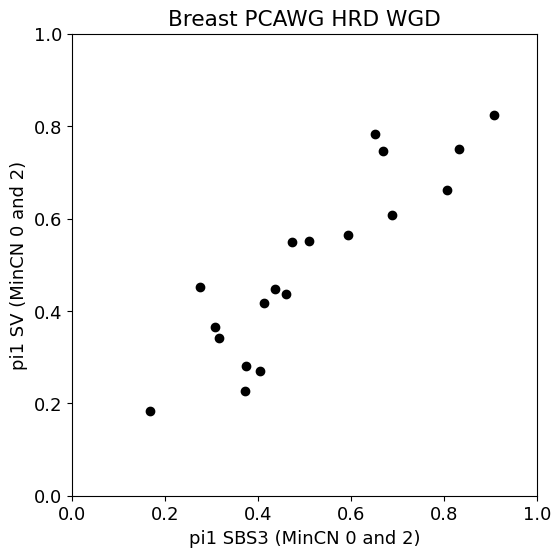

In [17]:
df_all = (
    pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/All_data_Jun11.csv")
    .assign(
        pi1_SBS3_list=lambda d: d['pi1SBS3'].apply(lambda x: [float(i) for i in x.strip('[]').split(', ')] if pd.notnull(x) else []),
        N_mut_all_list=lambda d: d['N_mut_all'].apply(lambda x: [float(i) for i in x.strip('[]').split(', ')] if pd.notnull(x) else [])
    )
    .assign(pi1_SBS3_weighted_0_2=lambda d: d.apply(
        lambda r: (r.pi1_SBS3_list[0] * r.N_mut_all_list[0] + r.pi1_SBS3_list[2] * r.N_mut_all_list[2]) / 
                  (r.N_mut_all_list[0] + r.N_mut_all_list[2]) if len(r.pi1_SBS3_list) >= 3 and len(r.N_mut_all_list) >= 3 and (r.N_mut_all_list[0] + r.N_mut_all_list[2]) > 0 else np.nan,
        axis=1
    ))
    .query("cohort == 'PCAWG'")
)

common_ids = list(set(pi1_SVs['ID']).intersection(df_all['ID']))

plot_df = (
    pd.DataFrame({
        'pi1_SV_weighted_avg': pi1_SVs.set_index('ID').loc[common_ids, 'pi1_SV_weighted_avg'],
        'pi1_SBS3_weighted_0_2': df_all.set_index('ID').loc[common_ids, 'pi1_SBS3_weighted_0_2']
    })
    .dropna()
)

plt.figure(figsize=(6,6))
plt.scatter(plot_df['pi1_SBS3_weighted_0_2'], plot_df['pi1_SV_weighted_avg'], alpha=1, color='k')
plt.xlabel('pi1 SBS3 (MinCN 0 and 2)')
plt.ylabel('pi1 SV (MinCN 0 and 2)')
plt.title('Breast PCAWG HRD WGD')
plt.ylim(0,1)
plt.xlim(0,1)
plt.show()


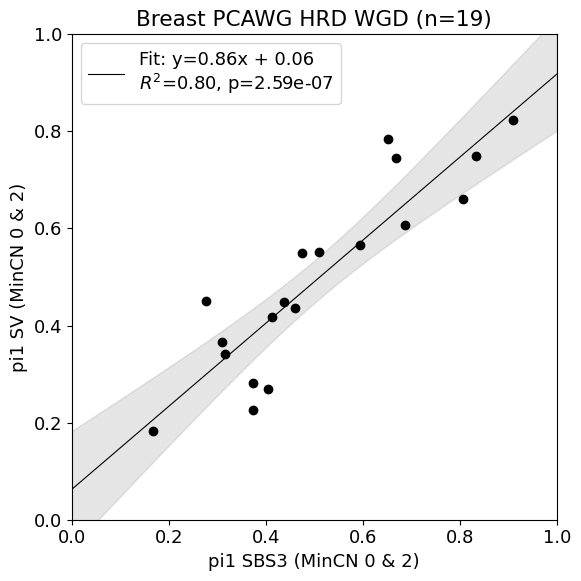

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size': 13, 'pdf.fonttype': 42})

x_clean = plot_df['pi1_SBS3_weighted_0_2'].values
y_clean = plot_df['pi1_SV_weighted_avg'].values

plt.scatter(x_clean, y_clean, color='k', alpha=1, zorder=20)

# Fit linear regression
X = sm.add_constant(x_clean)
model = sm.OLS(y_clean, X)
results = model.fit()

# Prediction + CI
x_pred = np.linspace(0, 1, 100)
X_pred = sm.add_constant(x_pred)
predictions = results.get_prediction(X_pred)
pred_summary = predictions.summary_frame(alpha=0.05)

# Plot line + CI
plt.plot(x_pred, pred_summary['mean'], 'k-', linewidth=0.8,
         label=f'Fit: y={results.params[1]:.2f}x + {results.params[0]:.2f}\n'
               f'$R^2$={results.rsquared:.2f}, p={results.pvalues[1]:.3g}')
plt.fill_between(x_pred, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'], color='grey', alpha=0.2)

plt.xlabel('pi1 SBS3 (MinCN 0 & 2)')
plt.ylabel('pi1 SV (MinCN 0 & 2)')
plt.title(f'Breast PCAWG HRD WGD (n={len(plot_df)})')
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/pi1_SV_pi1_SBS3_20_22.pdf", format='pdf', bbox_inches='tight')
plt.show()


# HRD Score

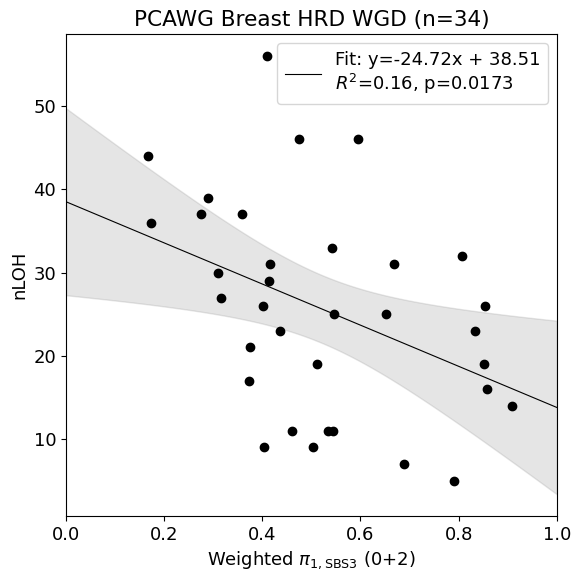

In [19]:
# Load data
df_all = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/All_data_Jun11.csv")

# Parse columns
def parse_list_column(col):
    return col.apply(lambda x: [float(i) for i in x.strip('[]').split(', ')] if pd.notnull(x) else [])

df_all['pi1_SBS3_list'] = parse_list_column(df_all['pi1SBS3'])
df_all['N_mut_all_list'] = parse_list_column(df_all['N_mut_all'])

# Weighted average at indices 0 and 2
def weighted_pi1_sbs3(row):
    pi_list = row['pi1_SBS3_list']
    n_list = row['N_mut_all_list']
    if len(pi_list) >= 3 and len(n_list) >= 3:
        num = pi_list[0] * n_list[0] + pi_list[2] * n_list[2]
        denom = n_list[0] + n_list[2]
        return num / denom if denom > 0 else np.nan
    return np.nan

df_all['pi1_SBS3_weighted_0_2'] = df_all.apply(weighted_pi1_sbs3, axis=1)

# Filter to PCAWG cohort
df_all = df_all[df_all['cohort'] == 'PCAWG']

# Load HRD scores
HRD_score_df = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/input/20240216_pcawg_hrd_scar_HRDscar.tsv", sep='\t')
HRD_score_df = HRD_score_df[HRD_score_df['aliquot_id'].isin(df_all['ID'])]

# Merge on aliquot ID
plot_df = df_all.merge(HRD_score_df[['aliquot_id', 'tnbc.nLOH']], left_on='ID', right_on='aliquot_id')

# Remove NaNs
plot_df = plot_df[['pi1_SBS3_weighted_0_2', 'tnbc.nLOH']].dropna()

# Extract x and y
x_clean = plot_df['pi1_SBS3_weighted_0_2'].values
y_clean = plot_df['tnbc.nLOH'].values

# Plot setup
plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size': 13, 'pdf.fonttype': 42})

# Scatter
plt.scatter(x_clean, y_clean, color='k', alpha=1, zorder=20)

# Fit linear model
X = sm.add_constant(x_clean)
model = sm.OLS(y_clean, X)
results = model.fit()

# Define x range from 0 to 1
x_pred = np.linspace(0, 1, 100)
X_pred = sm.add_constant(x_pred)

# Get predictions
predictions = results.get_prediction(X_pred)
pred_summary = predictions.summary_frame(alpha=0.05)

# Plot regression line and CI
plt.plot(x_pred, pred_summary['mean'], 'k-', linewidth=0.8,
         label=f'Fit: y={results.params[1]:.2f}x + {results.params[0]:.2f}\n'
               f'$R^2$={results.rsquared:.2f}, p={results.pvalues[1]:.3g}')
plt.fill_between(x_pred, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'], color='grey', alpha=0.2)

# Axis limits and labels
plt.xlabel('Weighted $\pi_{1,\mathrm{SBS3}}$ (0+2)')
plt.ylabel('nLOH')
plt.title(f'PCAWG Breast HRD WGD (n={len(x_clean)})')
plt.xlim(0, 1)
plt.legend()
plt.tight_layout()
plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/HRDScore_pi1_SBS3_20_22.pdf", format='pdf', bbox_inches='tight')
plt.show()


                            OLS Regression Results                            
Dep. Variable:                HRD_lag   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.253
Date:                Tue, 01 Jul 2025   Prob (F-statistic):              0.300
Time:                        09:16:46   Log-Likelihood:                -215.47
No. Observations:                  59   AIC:                             440.9
Df Residuals:                      54   BIC:                             451.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6

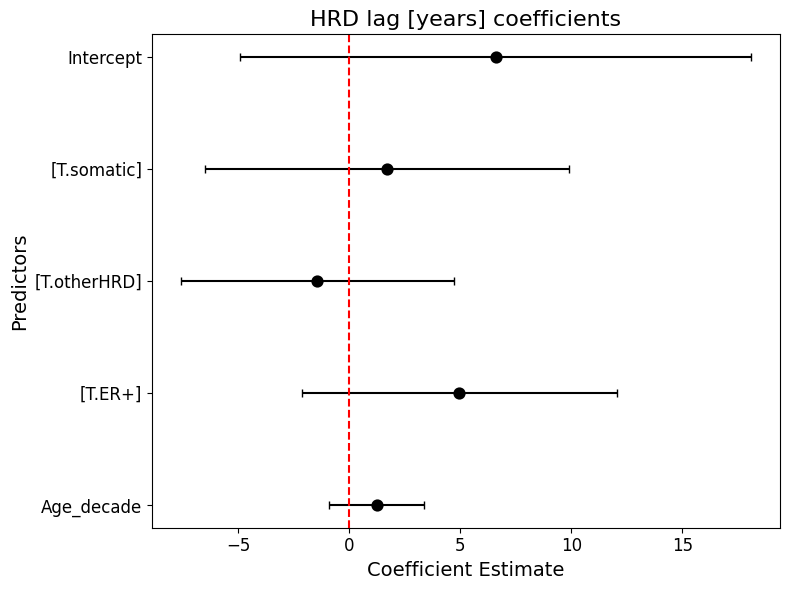

In [4]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load and process HRD lag data ---
HRD_lag = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/All_data_Jun30.csv")
HRD_lag = HRD_lag[['ID', 'sample.display', 'Age', 'Age_HRD_norm_int', 'removed']]
HRD_lag = HRD_lag[HRD_lag['removed'] == False].dropna(subset=['Age'])
HRD_lag['HRD_lag'] = HRD_lag['Age'] - HRD_lag['Age_HRD_norm_int']
HRD_lag['Age_decade'] = HRD_lag['Age'] / 10

# --- Load metadata and filter to matched IDs ---
meta = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/metadata/pan_metadata_v5.csv")
meta = meta[['sample', 'hrd.origin', 'type']]
meta = meta[meta['sample'].isin(HRD_lag['ID'])]

merged_df = pd.merge(HRD_lag, meta, left_on='ID', right_on='sample', how='inner')
merged_df = merged_df.dropna(subset=['HRD_lag', 'Age_decade', 'hrd.origin', 'type'])

merged_df['hrd_origin'] = merged_df['hrd.origin'].astype('category')
merged_df['type'] = merged_df['type'].astype('category')

# --- Fit regression model ---
model = smf.ols(
    "HRD_lag ~ Age_decade + C(type, Treatment(reference=None)) + C(hrd_origin, Treatment(reference=None))  - 1",
    data=merged_df
).fit()
# Fit the multivariate linear regression model
merged_df['type'] = pd.Categorical(merged_df['type'], categories=['TN', 'ER+'], ordered=True)
merged_df['hrd_origin'] = pd.Categorical(merged_df['hrd_origin'], categories=['germline', 'somatic', 'otherHRD'], ordered=True)
model = smf.ols("HRD_lag ~ Age_decade + hrd_origin + type", data=merged_df).fit()
print(model.summary())

# --- Extract coefficients and confidence intervals ---
coef_df = model.summary2().tables[1].reset_index()
coef_df.columns = ['term', 'coef', 'std_err', 't', 'P>|t|', 'conf_low', 'conf_high']
coef_df = coef_df[~coef_df['term'].str.contains("Unknown", na=False)]
coef_df['term'] = coef_df['term'].str.replace("hrd_origin", "", regex=False)
coef_df['term'] = coef_df['term'].str.replace("type", "", regex=False)

# --- Plot coefficients ---
plt.figure(figsize=(8, 6))
sns.pointplot(data=coef_df, y='term', x='coef',linestyle='none', color='black')
plt.errorbar(coef_df['coef'], coef_df['term'],
             xerr=[coef_df['coef'] - coef_df['conf_low'], coef_df['conf_high'] - coef_df['coef']],
             fmt='none', c='black', capsize=3)
plt.axvline(0, color='red', linestyle='--')
plt.title("HRD lag [years] coefficients", fontsize=16)
plt.xlabel("Coefficient Estimate", fontsize=14)
plt.ylabel("Predictors", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

